# Import libraries and initialize const

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models, losses, optimizers, metrics, callbacks
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import imdb
import re

In [2]:
VOCAB_SIZE = 25000
MAXLEN = 256
EMBED_DIM = 64
BATCH_SIZE = 64
EPOCHS = 100
SEED = 42

# Load and split the data

In [3]:
def load_imdb_numpy(num_words=VOCAB_SIZE, split=(0.8, 0.1, 0.1), seed=SEED):
    train_ratio, val_ratio, test_ratio = split

    # 1) Load 50k mẫu (25k train + 25k test) và giới hạn từ vựng cho phù hợp mô hình
    (x_tr, y_tr), (x_te, y_te) = tf.keras.datasets.imdb.load_data(num_words=num_words)

    # 2) Gộp toàn bộ để chủ động chia 8:1:1 (tối đa hóa dữ liệu train)
    x_all = np.array(list(x_tr) + list(x_te), dtype=object)
    y_all = np.array(list(y_tr) + list(y_te), dtype=np.int32)

    # 3) Chia train vs temp (val+test) có stratify để cân bằng nhãn
    X_train, X_temp, y_train, y_temp = train_test_split(
        x_all, y_all,
        test_size=val_ratio + test_ratio,
        random_state=seed,
        shuffle=True,
        stratify=y_all
    )

    # 4) Chia tiếp temp thành val và test theo tỉ lệ yêu cầu (giữ stratify)
    temp_val_fraction = val_ratio / (val_ratio + test_ratio) if (val_ratio + test_ratio) > 0 else 0
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp,
        test_size=1 - temp_val_fraction,
        random_state=seed,
        shuffle=True,
        stratify=y_temp
    )

    # 5) Đảm bảo tất cả là NumPy arrays (x là object array, y là int32)
    X_train = np.array(X_train, dtype=object)
    X_val   = np.array(X_val,   dtype=object)
    X_test  = np.array(X_test,  dtype=object)

    y_train = np.array(y_train, dtype=np.int32)
    y_val   = np.array(y_val,   dtype=np.int32)
    y_test  = np.array(y_test,  dtype=np.int32)

    return X_train, y_train, X_val, y_val, X_test, y_test

In [4]:
X_train, y_train, X_val, y_val, X_test, y_test = load_imdb_numpy(num_words=VOCAB_SIZE, split=(0.8, 0.1, 0.1), seed=SEED)

# Preprocessing data
---



In [5]:
X_train = pad_sequences(X_train, maxlen=MAXLEN, padding="post", truncating="pre", value=0)
X_val = pad_sequences(X_val, maxlen=MAXLEN, padding="post", truncating="pre", value=0)
X_test = pad_sequences(X_test, maxlen=MAXLEN, padding="post", truncating="pre", value=0)

train = (tf.data.Dataset.from_tensor_slices((X_train, y_train))
            .shuffle(buffer_size=10000, seed=SEED, reshuffle_each_iteration=True)
            .batch(BATCH_SIZE, drop_remainder = True)
            .prefetch(tf.data.AUTOTUNE))

val  = (tf.data.Dataset.from_tensor_slices((X_val, y_val))
           .batch(BATCH_SIZE, drop_remainder = False)
           .cache()
           .prefetch(tf.data.AUTOTUNE))

test = (tf.data.Dataset.from_tensor_slices((X_test, y_test))
           .batch(BATCH_SIZE, drop_remainder =False)
           .cache()
           .prefetch(tf.data.AUTOTUNE))

# Build model

In [6]:
def build_birnn():
    stacked_model = models.Sequential([
      layers.Embedding(VOCAB_SIZE, EMBED_DIM, input_length=MAXLEN, mask_zero=True),
      layers.SpatialDropout1D(0.2),
      layers.Bidirectional(
            layers.SimpleRNN(64, activation="tanh",
                             dropout=0.2,
                             return_sequences=True),  # phát ra [B, T, 2*64] sau merge
            merge_mode="concat"),
      layers.GlobalAveragePooling1D(),
      layers.Dropout(0.5),
      layers.Dense(32, activation="relu"),
      layers.Dropout(0.5),
      layers.Dense(1, activation="sigmoid")
     ])
    stacked_model.compile(
        optimizer=keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-3),
        loss=keras.losses.BinaryCrossentropy(label_smoothing=0.05),
        metrics=["accuracy"]
    )
    return stacked_model

def build_bilstm(vocab_size=VOCAB_SIZE, embed_dim=EMBED_DIM, maxlen=MAXLEN, units=64, merge_mode="concat"):
    inputs = layers.Input(shape=(maxlen,), dtype="int32")

    # Embedding + SpatialDropout
    x = layers.Embedding(vocab_size, embed_dim, mask_zero=True)(inputs)
    x = layers.SpatialDropout1D(0.2)(x)

    x = layers.Bidirectional(
            layers.LSTM(units=units, return_sequences=True),
            merge_mode=merge_mode
        )(x)

    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(units // 2, activation="relu")(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer=keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-2),
        loss=keras.losses.BinaryCrossentropy(label_smoothing=0.05),
        metrics=["accuracy"]
    )
    return model

def build_bigru(vocab_size=VOCAB_SIZE, embed_dim=EMBED_DIM, maxlen=MAXLEN,
                units=64, merge_mode="concat"):
    inputs = layers.Input(shape=(maxlen,), dtype="int32")

    # Embedding + SpatialDropout
    x = layers.Embedding(vocab_size, embed_dim, mask_zero=True)(inputs)
    x = layers.SpatialDropout1D(0.2)(x)

    x = layers.Bidirectional(
            layers.GRU(units,
                       return_sequences=True,
                       reset_after=True),
            merge_mode=merge_mode
        )(x)

    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(units // 2, activation="relu")(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer=keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-3),
        loss=keras.losses.BinaryCrossentropy(label_smoothing=0.05),
        metrics=["accuracy"]
    )
    return model

def build_Conv1D(vocab_size=VOCAB_SIZE, embed_dim=EMBED_DIM, maxlen=MAXLEN):
    inputs = layers.Input(shape=(maxlen,), dtype="int32")
    x = layers.Embedding(vocab_size, embed_dim, mask_zero=True)(inputs)
    x = layers.Conv1D(32, 3, activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs)
    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-3),
        loss=keras.losses.BinaryCrossentropy(label_smoothing=0.05),
        metrics=["accuracy"]
    )
    return model

model = build_bigru()
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'global_max_pooling1d' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 256, 64)   │  1,600,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d   │ (None, 256, 64)   │          0 │ embedding[0][0]   │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 256)       │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 256, 128)  │     49,920 │ spatial_dropout1… │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ bidirectional[0]… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │      4,128 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         33 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,654,081 (6.31 MB)

 Trainable params: 1,654,081 (6.31 MB)

 Non-trainable params: 0 (0.00 B)

# Train model

In [7]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True, monitor='val_loss'),
    keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-5)
]

history = model.fit(
    train,
    validation_data=val,
    epochs=100,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.6510 - loss: 0.5951 - val_accuracy: 0.8924 - val_loss: 0.3220 - learning_rate: 0.0010
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - accuracy: 0.9081 - loss: 0.3143 - val_accuracy: 0.9014 - val_loss: 0.3008 - learning_rate: 0.0010
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.9455 - loss: 0.2492 - val_accuracy: 0.9080 - val_loss: 0.3037 - learning_rate: 0.0010
Epoch 4/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.9661 - loss: 0.2082 - val_accuracy: 0.8982 - val_loss: 0.3509 - learning_rate: 0.0010
Epoch 5/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.9785 - loss: 0.1847 - val_accuracy: 0.8918 - val_loss: 0.3624 - learning_rate: 0.0010
Epoch 6/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.9869 - loss: 0.1674 - val_accuracy: 0.9026 - val_loss: 0.3413 - learning_rate: 5.0000e-04
Epoch 7/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy:

# Evaluate

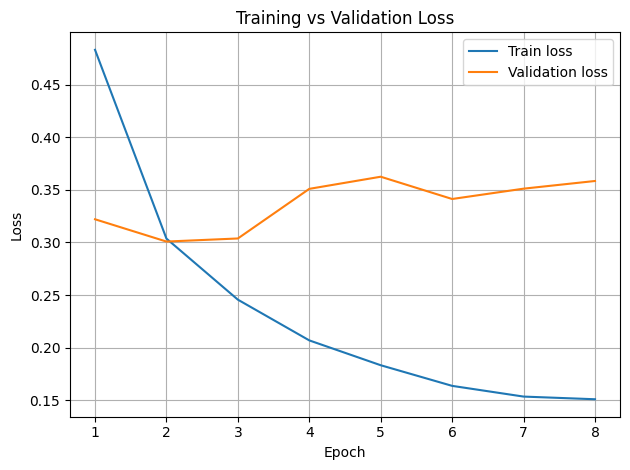

In [8]:
import matplotlib.pyplot as plt

def plot_train_val_loss(history, title="Training vs Validation Loss"):
    # history: đối tượng trả về bởi model.fit(...) hoặc dict history.history
    hist = history.history if hasattr(history, "history") else history

    train_loss = hist.get("loss")
    val_loss   = hist.get("val_loss")
    if train_loss is None or val_loss is None:
        raise ValueError('Thiếu "loss" hoặc "val_loss" trong history. Hãy đảm bảo fit có validation_data.')

    epochs = range(1, len(train_loss) + 1)

    plt.figure()
    plt.plot(epochs, train_loss, label="Train loss")
    plt.plot(epochs, val_loss,   label="Validation loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Gọi:
plot_train_val_loss(history)

In [9]:
test_loss, test_acc = model.evaluate(test, verbose=0)
print(f"Test (weighted) loss: {test_loss:.4f} | acc: {test_acc:.4f}")

Test (weighted) loss: 0.3105 | acc: 0.9024


# Test

In [10]:
INDEX_FROM = 3     # offset 3: 0=PAD, 1=START, 2=OOV
START = 1
OOV = 2
PAD = 0

VOCAB_SIZE = 25000
MAXLEN = 256

# Tải word_index gốc rồi cộng offset=3 để khớp với dữ liệu train
_raw_wi = imdb.get_word_index()
word_index = {w: (i + INDEX_FROM) for w, i in _raw_wi.items()}

def encode_imdb_text(text, vocab_size=VOCAB_SIZE, maxlen=MAXLEN):
    """
    text -> sequence chỉ số theo quy ước IMDB (START=1, OOV=2, PAD=0)
    - lowercase + tách token đơn giản
    - từ nào không có trong word_index hoặc >= vocab_size -> OOV
    - pad về maxlen với PAD=0, truncating='pre' để khớp pipeline lúc train
    """
    # tách token: chữ, số, apostrophe
    tokens = re.findall(r"[a-z0-9']+", text.lower())

    seq = [START]
    for w in tokens:
        idx = word_index.get(w, OOV)
        if idx >= vocab_size:
            idx = OOV
        seq.append(idx)

    x = pad_sequences([seq], maxlen=maxlen, padding="post", truncating="pre", value=PAD)
    return x  # shape (1, maxlen) int32

def predict_sentence(text, threshold=0.5):
    """
    Trả về (prob_positive, label_str).
    Yêu cầu: biến 'model' đã là model Keras bạn huấn luyện trước đó.
    """
    x = encode_imdb_text(text)
    prob = float(model.predict(x, verbose=0)[0, 0])  # xác suất positive
    label = "positive" if prob >= threshold else "negative"
    return prob, label

In [11]:
sentence = "So fucking bad"
x_demo = encode_imdb_text(sentence)
prob, label = predict_sentence(sentence)
print(f"Prob positive: {prob:.3f}  -->  {label}")

Prob positive: 0.193  -->  negative
